# Intro Task, Object Localization

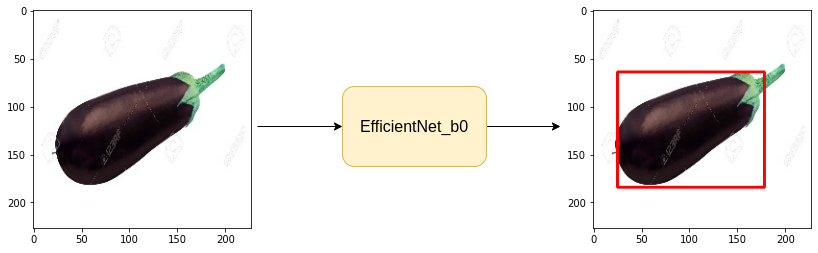

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rzo9rtz5
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rzo9rtz5
  Resolved https://github.com/albumentations-team/albumentations to commit ad51312f6f6dd6a9729f17292a7aa3d5114a1b00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 836.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 10.6 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.20-py3-none-any.whl size=225606 sha256=641614d8fc1a024a91f85732aea20f2293e874adf756182673e1942320e60b74
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7edyfoc/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: al

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 6.83 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
DATA_DIR = "/content/object-localization-dataset/"
CSV_FILE = "/content/object-localization-dataset/train.csv"
EPOCHS = 10
LR = 0.001
BATCH_SIZE = 16
DEVICE = "cuda"
IMG_SIZE = 140
MODEL_NAME = "efficientnet_b0"
NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

In [7]:
train_df, valid_df = train_test_split(df,test_size=0.2,random_state=42)
print(f"train set : {len(train_df)}, Valid set: {len(valid_df)}")

train set : 148, Valid set: 38


# Augmentations

In [8]:
import albumentations as A

In [9]:
train_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
valid_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [10]:
class ObjectLocaDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return(len(self.df))

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin,ymin,xmax,ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image=img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]
    img = torch.from_numpy(img).permute(2,0,1) / 255.0
    bbox = torch.Tensor(bbox)
    return img, bbox

In [11]:
trainset = ObjectLocaDataset(train_df,train_aug)
validset = ObjectLocaDataset(valid_df)

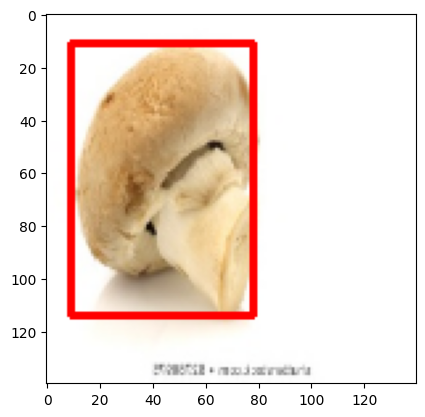

In [12]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [13]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE,)

In [14]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [15]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [44]:
from torch import nn
import timm

In [45]:
class ObjectLocModel(nn.Module):
  def __init__(self):
    super(ObjectLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained=True,num_classes=4)

  def forward(self,image,gt_bboxes=None):
      bboxes = self.backbone(images)

      if gt_bboxes != None:
        loss = nn.MSELoss(bboxes,gt_bboxes)
        return bboxes, loss
      return bboxes

In [46]:
model = ObjectLocModel()
model.to(DEVICE);

# Create Train and Eval Function

In [47]:
def train_fn(model,dataloader,optimizer):

  total_loss = 0.0
  model.train()

  for batch in tqdm(dataloader):

    image, gt_bboxes = batch

    bboxes, loss = model(image, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)


In [48]:
def eval_fn(model,dataloader):

  total_loss = 0.0
  model.eval()

  for batch in tqdm(dataloader):

    image, gt_bboxes = batch

    bboxes, loss = model(image, gt_bboxes)

    total_loss += loss.item()

  return total_loss / len(dataloader)


#Training Loop

In [49]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [50]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.stat_dict(), "best-model.pt")
    print("WEIGHT ARE SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch {i+1} train loss: {train_loss}, Valid loss: {valid_loss} ")


  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

#Inference

In [ ]:
import utils

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya